In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

In [4]:
# run this if you are using colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# if this does not run, change to the file path where ALL is located on your device
!unzip gdrive/MyDrive/ALL.zip

Streaming output truncated to the last 5000 lines.
  inflating: ALL/all_pro/all_pro_4792.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_4792.jpg  
  inflating: ALL/all_pro/all_pro_1832.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1832.jpg  
  inflating: ALL/all_pro/all_pro_0292.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0292.jpg  
  inflating: ALL/all_pro/all_pro_3943.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3943.jpg  
  inflating: ALL/all_pro/all_pro_2485.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2485.jpg  
  inflating: ALL/all_pro/all_pro_3957.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3957.jpg  
  inflating: ALL/all_pro/all_pro_2491.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2491.jpg  
  inflating: ALL/all_pro/all_pro_0286.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0286.jpg  
  inflating: ALL/all_pro/all_pro_1198.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1198.jpg  
  inflating: ALL/all_pro/all_pro_1826.jpg  
  inflating: _

In [6]:
data_dir = 'ALL'

In [7]:
# training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% train
    subset="training",
    seed=123,
    image_size=(128, 128),  # resize all images
    batch_size=32
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3, # 30% temporary dataset
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

Found 20000 files belonging to 4 classes.
Using 14000 files for training.
Found 20000 files belonging to 4 classes.
Using 6000 files for validation.


In [8]:
# split temp_ds into val (50%) + test (50%) -> 15% each
# temp_ds originally has 6000 (files) / 32 (batch size) = 187.5 (round up = 188)
val_batches = tf.data.experimental.cardinality(temp_ds) # cardinality is the rounded number of batches
val_ds = temp_ds.take(val_batches // 2) # takes first half
test_ds = temp_ds.skip(val_batches // 2) # skips first half and takes second half

# expect cardinality = 94 (188 / 2)
print("Cardinality of validation set:", tf.data.experimental.cardinality(val_ds).numpy())
print("Cardinality of test set:", tf.data.experimental.cardinality(test_ds).numpy())

Cardinality of validation set: 94
Cardinality of test set: 94


In [9]:
# normalize the data so that values are [0,1] instead of [0,255]
# improves convergence speed and ensures consistency among all features
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
# use GPU if available
if torch.cuda.is_available():
  print("GPU detected")
  device = torch.device("cuda")
else:
  print("No GPU detected")
  device = torch.device("cpu")

GPU detected


In [14]:
num_classes = 4  # benign, early, pre, pro
epochs = 15

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.5512 - loss: 1.2021 - val_accuracy: 0.8142 - val_loss: 0.5114
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.8215 - loss: 0.4577 - val_accuracy: 0.8830 - val_loss: 0.2954
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.8988 - loss: 0.2820 - val_accuracy: 0.8873 - val_loss: 0.2901
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9223 - loss: 0.2101 - val_accuracy: 0.9272 - val_loss: 0.1891
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9411 - loss: 0.1616 - val_accuracy: 0.9435 - val_loss: 0.1565
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9673 - loss: 0.0991 - val_accuracy: 0.9358 - val_loss: 0.2081
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9594 - loss: 0.1247 - val_accuracy: 0.9481 - val_loss: 0.1399
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9835 - loss: 0.0464 - val_accurac

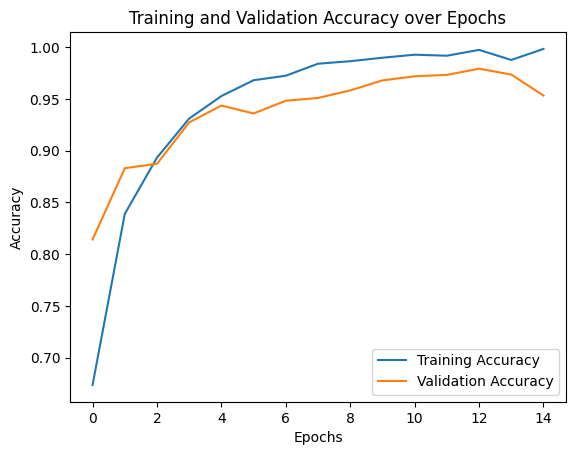

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(epochs), train_acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()